In [60]:
# The analysis of the baseball data to answer the desired 
# questions are in SQL format and need to be queried into pandas

# SQLite will be cross-platform for this propuse 

In [61]:
# MARK: IMPORTS

import pandas as pd
import sqlite3

%matplotlib inline

In [62]:
# MARK: METHODS

# File location
sqlite_file = '/Users/cottalucas/Documents/dataScience/ds-2017-05/week-01-toolkit/data/lahman2016_data/lahman2016.sqlite'

# Connecting with the DB
def connect(sqlite_file):
    conn = sqlite3.connect(sqlite_file)
    c = conn.cursor()
    return conn, c

# Closing connection (non-commiting)
def close(conn):
    conn.close()

# Returns a table coll information
def table_col_info(cursor, table_name, print_out=False):

    c.execute('PRAGMA TABLE_INFO({})'.format(table_name))
    info = c.fetchall()

    if print_out:
        print("\nColumn Info:\nID, Name, Type, NotNull, DefaultVal, PrimaryKey")
        for col in info:
            print(col)
    return info

In [63]:
# MARK: Open connection

conn, c = connect(sqlite_file)

### Which player hit the most home runs in 2002?

In [64]:
player_hr_df = pd.read_sql("""
SELECT t2.Name AS Name, t1.HomeRun AS Homerun 
FROM
(SELECT playerID AS Players, SUM(HR)  AS HomeRun 
FROM Batting
WHERE yearID == 2002 
GROUP BY playerID) t1 
INNER JOIN 
(SELECT playerID AS Players, nameGiven AS Name
FROM Master) AS t2
ON t1.Players = t2.Players
ORDER BY HomeRun DESC""",conn)


player_hr_df.head(3)

,Name,Homerun
0,Alexander Enmanuel,57
1,James Howard,52
2,Samuel Peralta,49


### Which team spent the most/least money on player salaries in 2002?

In [65]:
team_salary_df = pd.read_sql("""
SELECT t1.teamSalary, t2.name
FROM
(SELECT teamID, SUM(salary) AS teamSalary
FROM Salaries
WHERE yearID == 2002
GROUP BY teamID) AS t1
INNER JOIN
(SELECT teamID, name
FROM Teams
WHERE yearID == 2002
GROUP BY teamID) as t2
ON t1.teamID = t2.teamID
ORDER BY teamSalary DESC
""", conn)

team_salary_df.head(3)

,teamSalary,name
0,125928583,New York Yankees
1,108366060,Boston Red Sox
2,105526122,Texas Rangers


In [66]:
team_salary_df.tail(1)

,teamSalary,name
29,34380000,Tampa Bay Devil Rays


### Which player averaged the fewest at bats between home runs in 2002?

In [75]:
player_avg_df = pd.read_sql("""
SELECT t2.nameGiven AS Players, t1.Result AS Result
FROM
(SELECT HR, (AB*1.0)/HR AS Result, playerID AS Players
FROM Batting
WHERE yearID = 2002
AND HR > 3
GROUP BY Players) t1
INNER JOIN
(SELECT playerID AS Players, nameGiven
FROM Master) AS t2
ON t1.Players = t2.Players
ORDER BY Result""", conn)

player_avg_df.dropna().head(5)

,Players,Result
0,Barry Lamar,8.760870
1,James Howard,9.230769
2,Alexander Enmanuel,10.947368
3,Todd Anthony,11.200000
4,Samuel Peralta,11.346939


### Which player in 2002 had the highest on-base percentage

In [80]:
highest_on_base_df = pd.read_sql("""
SELECT t2.nameGiven AS Player, t1.H AS H, t1.BB AS BB, CAST(t1.HBP AS Integer) AS HBP, t1.AB AS AB, CAST(t1.SF AS Integer) AS SF
FROM
(SELECT  H,BB,HBP,AB,SF, playerID
FROM Batting
WHERE yearID = 2002
AND AB >= 10) AS t1
INNER JOIN
(SELECT playerID, nameGiven
FROM Master) AS t2
ON t1.playerID = t2.playerID
WHERE H AND BB AND HBP AND AB AND SF IS NOT NULL""", conn)

# formula from https://en.wikipedia.org/wiki/On-base_percentage

highest_on_base_df['OnBase%'] = (highest_on_base_df.H + highest_on_base_df.BB + highest_on_base_df.HBP)/(highest_on_base_df.AB + highest_on_base_df.BB + highest_on_base_df.HBP + highest_on_base_df.SF)
highest_on_base_df.sort_values('OnBase%', ascending=False).head(7)

,Player,H,BB,HBP,AB,SF,OnBase%
33,Barry Lamar,149,198,9,403,2,0.581699
209,Michael Arthur,19,4,6,50,0,0.483333
130,Brian Stephen,148,135,7,497,5,0.450311
331,Manuel Aristides,152,73,8,436,1,0.449807
324,Todd Alan,33,24,4,106,2,0.448529
384,James Howard,146,122,5,480,6,0.445351
126,Jason Gilbert,176,109,15,560,5,0.435414


In [69]:
highest_on_base_df.tail()

,Player,H,BB,HBP,AB,SF,OnBase%
428,Dmitri Dell,57,12,2,201,1,0.328704
429,Eric Orlando,139,39,6,496,4,0.337615
430,Kevin Stacey,115,50,4,468,3,0.321905
431,Gregory Owen,41,12,2,185,1,0.275000
432,Todd Edward,138,66,1,506,7,0.353448


### Which Yankees pitcher had the most wins in a season in the 00’s?

In [70]:
pitcher_wins = pd.read_sql("""
SELECT t1.teamID AS ID, t2.nameGiven AS nameGiven, t1.W AS W, t1.yearID AS yearID
FROM
(SELECT  teamID, playerID, W, yearID FROM Pitching
WHERE yearID > 1999 AND  yearID <2010) t1
INNER JOIN
(SELECT playerID, nameGiven
FROM Master) AS t2
ON (t1.playerID = t2.playerID) 
WHERE ID = 'NYA'
ORDER BY yearID""", conn)

pitcher_wins.sort_values('W', ascending=False).head()

,ID,nameGiven,W,yearID
75,NYA,Andrew Eugene,21,2003
199,NYA,Michael Cole,20,2008
25,NYA,William Roger,20,2001
15,NYA,Andrew Eugene,19,2000
155,NYA,Chien-Ming,19,2006


### In the 2000’s, did the Yankees draw more or fewer walks (Base-on-Balls or BB) as the decade went on?

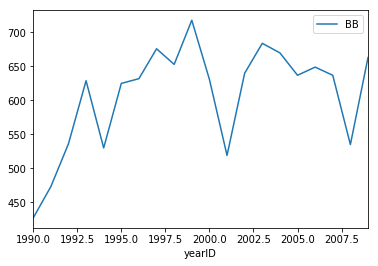

In [71]:
yankees_bb = pd.read_sql("""
SELECT teamID, BB, yearID FROM Teams
WHERE teamID = 'NYA' AND yearID > 1989 AND  yearID <2010""", conn)


yankees_bb.plot(x='yearID', y='BB')

In [72]:
yankees_bb

,teamID,BB,yearID
0,NYA,427,1990
1,NYA,473,1991
2,NYA,536,1992
3,NYA,629,1993
4,NYA,530,1994
5,NYA,625,1995
6,NYA,632,1996
7,NYA,676,1997
8,NYA,653,1998
9,NYA,718,1999


In [73]:
# MARK: Close connection

close(conn)